
Potato distribution pricing model

Case: Expand transport capacity



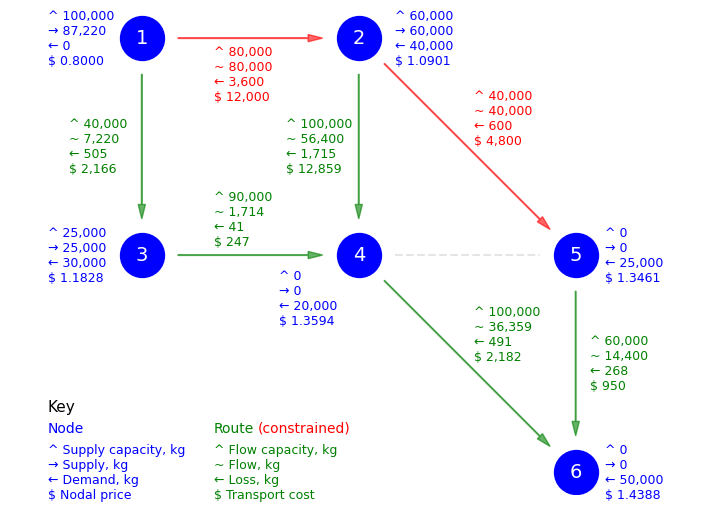


Cost summary
------------
Supply: $164,751.43
Transportation: $35,203.92
Total cost: $199,955.36

Supplier surplus: $9,475.62

Node details
------------

Node 1:
  Demand: 0.00 kg
  Offer: $0.8000/kg
  Price: $0.8000/kg
  Supply: 87,219.77 kg of 100,000.00 kg capacity
  Supply cost: $69,775.82
  Supplier surplus: $0.00

Node 2:
  Demand: 40,000.00 kg
  Offer: $1.0500/kg
  Price: $1.0901/kg
  Supply: 60,000.00 kg of 60,000.00 kg capacity
  Supply cost: $65,405.72
  Supplier surplus: $2,405.72

Node 3:
  Demand: 30,000.00 kg
  Offer: $0.9000/kg
  Price: $1.1828/kg
  Supply: 25,000.00 kg of 25,000.00 kg capacity
  Supply cost: $29,569.89
  Supplier surplus: $7,069.89

Node 4:
  Demand: 20,000.00 kg
  Offer: $1.1000/kg
  Price: $1.3594/kg
  Supply: 0.00 kg of 0.00 kg capacity
  Supply cost: $0.00
  Supplier surplus: $0.00

Node 5:
  Demand: 25,000.00 kg
  Offer: $1.1200/kg
  Price: $1.3461/kg
  Supply: 0.00 kg of 0.00 kg capacity
  Supply cost: $0.00
  Supplier surplus: $0.00

Node 6:
  D

In [1]:
# Potato LMP model, Pyomo
# www.solvermax.com

from pyomo.environ import *
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from data.data_scenario_current import *  # Change for scenario in data folder
from math import *

def complete_symmetric_data(data, default_value=None):  # Fill in opposite matrix values
    symmetric_data = data.copy()
    for (i, j) in list(data.keys()):
        symmetric_data[j, i] = data[i, j] if default_value is None else default_value
    return symmetric_data

def create_edges_from_network(node_data):  # Create directed edges from network connections
    edges = []
    for node, (_, _, _, connections) in node_data.items():
        for connected_node in connections:
            edges.append((node, connected_node))
            edges.append((connected_node, node))  # Ensure both directions
    return edges

def prepare_data():  # Read data from external file and prepare for model
    node_data = get_node_data()  # Get external data
    connection_data = get_connection_data()
    node_label_offsets, edge_label_offsets = get_plot_data()
    
    capacity_data = {n: data[0] for n, data in connection_data.items()}   # Process connection data
    distance_data = {n: data[1] for n, data in connection_data.items()}
    transport_rate = {n: data[2] for n, data in connection_data.items()}
    fixed_loss = {n: data[3] for n, data in connection_data.items()}
    var_loss = {n: data[4] for n, data in connection_data.items()}
    
    capacity = complete_symmetric_data(capacity_data)  # Create symmetric data
    distance = complete_symmetric_data(distance_data)
    rates = complete_symmetric_data(transport_rate)
    fixed_rate = complete_symmetric_data(fixed_loss)
    var_rate = complete_symmetric_data(var_loss)
    
    edges = create_edges_from_network(node_data)
    losses = {edge: fixed_rate[edge] + var_rate[edge] * distance[edge] for edge in edges}  # Calculate losses
    
    return {
        'node_data': node_data, 'edges': edges, 'capacity': capacity, 'distance': distance, 'rates': rates,
        'losses': losses, 'node_label_offsets': node_label_offsets, 'edge_label_offsets': edge_label_offsets
    }

def create_model(data):  # Create the model
    model = ConcreteModel()
    model.nodes = Set(initialize=data['node_data'].keys())
    model.edges = Set(initialize=data['edges'])
    model.max_supply = Param(model.nodes, initialize={n: node_data[0] for n, node_data in data['node_data'].items()})
    model.demand = Param(model.nodes, initialize={n: node_data[1] for n, node_data in data['node_data'].items()})
    model.supply_cost = Param(model.nodes, initialize={n: node_data[2] for n, node_data in data['node_data'].items()})
    model.capacity = Param(model.edges, initialize=data['capacity'])
    model.distance = Param(model.edges, initialize=lambda m, i, j: data['distance'][i, j])
    model.transport_rate = Param(model.edges, initialize=lambda m, i, j: data['rates'][i, j])
    model.losses = Param(model.edges, initialize=data['losses'])
    model.supply = Var(model.nodes, within=NonNegativeReals)
    model.flow = Var(model.edges, within=NonNegativeReals)
    
    def obj_rule(model):
        supply_costs = sum(model.supply_cost[n] * model.supply[n] for n in model.nodes)
        transport_costs = sum(model.flow[e] * model.distance[e] * model.transport_rate[e] for e in model.edges)
        return supply_costs + transport_costs
    model.obj = Objective(rule=obj_rule, sense=minimize)
    
    def supply_limit_rule(model, node):
        return model.supply[node] <= model.max_supply[node]
    model.supply_limit = Constraint(model.nodes, rule=supply_limit_rule)
    
    def flow_balance_rule(model, node):
        inflow = sum(model.flow[i, j] * (1 - model.losses[i, j]) for (i, j) in model.edges if j == node)
        outflow = sum(model.flow[i, j] for (i, j) in model.edges if i == node)
        return (model.supply[node] + inflow - outflow == model.demand[node])
    model.flow_balance = Constraint(model.nodes, rule=flow_balance_rule)
    
    def capacity_limit_rule(model, i, j):
        return model.flow[i, j] <= model.capacity[i, j]
    model.capacity_limit = Constraint(model.edges, rule=capacity_limit_rule)
    
    model.dual = Suffix(direction=Suffix.IMPORT_EXPORT)
    
    return model

def solve_model(model):  # Solve the model and check if solution found
    solver = SolverFactory('appsi_highs')
    result = solver.solve(model, load_solutions=False, tee=False)
    if (result.solver.status != SolverStatus.ok) or (result.solver.termination_condition != TerminationCondition.optimal):
        print('No solution.')
        print(f'Solver Status: {result.solver.status}')
        print(f'Termination Condition: {result.solver.termination_condition}')
        return None
    else:
        model.solutions.load_from(result)
        return result

def extract_results(model):  # Extract solution
    flows = {e: value(model.flow[e]) for e in model.edges}
    supplies = {n: value(model.supply[n]) for n in model.nodes}
    lmp = {n: model.dual[model.flow_balance[n]] for n in model.nodes}
    supplier_cost = sum(model.supply_cost[n] * supplies[n] for n in model.nodes)
    market_cost = sum(lmp[n] * supplies[n] for n in model.nodes)
    transport_cost = sum(flows[e] * model.distance[e] * model.transport_rate[e] for e in model.edges)
    return flows, supplies, lmp, supplier_cost, market_cost, transport_cost

def header():  # Print results header
    print('\nPotato distribution pricing model')
    print('=================================\n')
    print(f'Case: {case_name()}')
    
def print_results(model, flows, supplies, lmp, supplier_cost, market_cost, transport_cost):
    print('\nCost summary')
    print('------------')
    print(f'Supply: ${market_cost:,.2f}')
    print(f'Transportation: ${transport_cost:,.2f}')
    print(f'Total cost: ${(market_cost + transport_cost):,.2f}')
    print(f'\nSupplier surplus: ${(market_cost - supplier_cost):,.2f}')

    print('\nNode details')
    print('------------')
    for node in model.nodes:
        supply = abs(supplies[node])  # abs to remove spurious negative values
        print(f'\nNode {node}:')
        print(f'  Demand: {model.demand[node]:,.2f} kg')
        print(f'  Offer: ${model.supply_cost[node]:,.4f}/kg')
        print(f'  Price: ${lmp[node]:,.4f}/kg')
        print(f'  Supply: {supply:,.2f} kg of {model.max_supply[node]:,.2f} kg capacity')
        print(f'  Supply cost: ${lmp[node]*supply:,.2f}')
        print(f'  Supplier surplus: ${abs(lmp[node]-model.supply_cost[node])*supply:,.2f}')

    print('\nFlow details')
    print('------------')
    for edge in model.edges:
        flow = flows[edge]
        if flow > 0.01:
            loss = model.losses[edge]
            loss_qty = flow * loss
            transport_cost = flow * model.distance[edge] * model.transport_rate[edge]
            print(f'\nFlow from node {edge[0]} to Node {edge[1]}:')
            print(f'  Capacity: {model.capacity[edge]:,.2f} kg')
            print(f'  Flow: {flow:,.2f} kg')
            print(f'  Loss: {loss_qty:,.2f} kg ({loss*100:,.2f}%)')
            print(f'  Distance: {model.distance[edge]} km')
            print(f'  Transport rate: ${model.transport_rate[edge]:,.4f}/kg/km')
            print(f'  Transport cost: ${transport_cost:,.2f}')

def legend(plt):  # Create legend for network plot
    node_label = f'^ Supply capacity, kg\n→ Supply, kg\n← Demand, kg\n$ Nodal price'
    route_label = f'^ Flow capacity, kg\n~ Flow, kg\n← Loss, kg\n$ Transport cost'
    plt.text(0.07, 0.29, 'Key', fontsize=11, color='black', horizontalalignment='left', verticalalignment='center')
    plt.text(0.07, 0.26, 'Node', fontsize=10, color='blue', horizontalalignment='left', verticalalignment='center')
    plt.text(0.30, 0.26, 'Route', fontsize=10, color='green', horizontalalignment='left', verticalalignment='center')
    plt.text(0.36, 0.261, '(constrained)', fontsize=10, color='red', horizontalalignment='left', verticalalignment='center')
    plt.text(0.07, 0.20, node_label, fontsize=9, color='blue', horizontalalignment='left', verticalalignment='center')
    plt.text(0.30, 0.20, route_label, fontsize=9, color='green', horizontalalignment='left', verticalalignment='center')
    return plt

def initialize_figure():  # Create the network plot
    plt.figure(figsize=(9, 6.25))

def create_no_flow_pairs(edges, flows):  # Plot arcs with no flow
    no_flow_pairs = set()
    for edge in edges:
        node1, node2 = edge
        reverse_edge = (node2, node1)
        if flows.get(edge, 0) == 0 and flows.get(reverse_edge, 0) == 0:
            pair = tuple(sorted([node1, node2]))
            no_flow_pairs.add(pair)
    return no_flow_pairs

def create_possible_connections(node_data):  # Create plot arcs
    possible_connections = []
    for node, (_, _, _, connections) in node_data.items():
        for connected_node in connections:
            possible_connections.append((node, connected_node))
            possible_connections.append((connected_node, node))
    return possible_connections

def draw_edges_and_flows(edges, pos, flows, model, no_flow_pairs, possible_connections):  # Draw arcs on the network plot
    for edge in edges:
        if edge in possible_connections:
            start_pos = pos[edge[0]]
            end_pos = pos[edge[1]]
            dx = end_pos[0] - start_pos[0]
            dy = end_pos[1] - start_pos[1]
            length = np.sqrt(dx**2 + dy**2)
            edge_offset = 0.05
            dx, dy = dx / length, dy / length
            start_x = start_pos[0] + dx * edge_offset
            start_y = start_pos[1] + dy * edge_offset
            end_x = end_pos[0] - dx * edge_offset
            end_y = end_pos[1] - dy * edge_offset
            flow = flows.get(edge, 0)
            if flow > 0.01:
                arrow_color = 'red' if isclose(model.capacity[edge] - flow, 0) else 'green'
                plt.arrow(start_x, start_y, end_x - start_x, end_y - start_y, head_width=0.01, head_length=0.02,
                          fc=arrow_color, ec=arrow_color, length_includes_head=True, alpha=0.6)
            else:
                pair = tuple(sorted([edge[0], edge[1]]))
                if pair in no_flow_pairs:
                    plt.plot([start_x, end_x], [start_y, end_y], color='gray', alpha=0.2, linestyle='--')
                    no_flow_pairs.remove(pair)

def draw_nodes_and_labels(G, pos, model, supplies, lmp, node_label_offsets):  # Draw nodes on the network plot
    nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='blue', edgecolors='blue')
    nx.draw_networkx_labels(G, pos, labels={n: str(n) for n in G.nodes()}, font_size=14, font_color='white')
    for node in G.nodes():
        x, y = pos[node]
        offset_x, offset_y = node_label_offsets.get(node, (0.05, 0))
        label = f'^ {model.max_supply[node]:,.0f}\n→ {abs(supplies[node]):,.0f}\n← {G.nodes[node]["demand"]:,.0f}\n$ {lmp[node]:,.4f}'
        plt.text(x + offset_x, y + offset_y, label, fontsize=9, color='blue', horizontalalignment='left', verticalalignment='center')

def draw_edge_labels(G, edges, pos, flows, model, distance, edge_label_offsets):  # Draw labels on the network plot
    for edge in edges:
        flow = flows.get(edge, 0)
        if flow > 0.01:
            start_pos = pos[edge[0]]
            end_pos = pos[edge[1]]
            mid_x = (start_pos[0] + end_pos[0]) / 2
            mid_y = (start_pos[1] + end_pos[1]) / 2
            offset_x, offset_y = edge_label_offsets.get(edge, (0, 0.05))
            label_x = mid_x + offset_x
            label_y = mid_y + offset_y
            loss = G.edges[edge]["loss"]
            loss_qty = flow * loss
            transport_cost = flow * distance[edge] * model.transport_rate[edge]
            text_color = 'red' if isclose(model.capacity[edge] - flow, 0) else 'green'
            label = f'^ {model.capacity[edge]:,.0f}\n~ {flow:,.0f}\n← {loss_qty:,.0f}\n$ {transport_cost:,.0f}'
            plt.text(label_x, label_y, label, fontsize=9, color=text_color, horizontalalignment='left', verticalalignment='center')

def create_network_graph(G, pos, flows, supplies, lmp, edges, distance, model, node_data, node_label_offsets, edge_label_offsets):  # Create the network plot
    initialize_figure()
    no_flow_pairs = create_no_flow_pairs(edges, flows)
    possible_connections = create_possible_connections(node_data)
    draw_edges_and_flows(edges, pos, flows, model, no_flow_pairs, possible_connections)
    draw_nodes_and_labels(G, pos, model, supplies, lmp, node_label_offsets)
    draw_edge_labels(G, edges, pos, flows, model, distance, edge_label_offsets)
    legend(plt)
    plt.axis('off')
    plt.axis('equal')
    
def draw_network_graph(model, data, flows, supplies, lmp):  # Draw the network plot
    G = nx.Graph()
    pos = get_node_positions()
    node_data = data['node_data']
    node_label_offsets = data['node_label_offsets']
    edge_label_offsets = data['edge_label_offsets']
    for node in model.nodes:  # Add nodes and edges to graph
        G.add_node(node, supply=supplies[node], demand=model.demand[node], lmp=lmp[node])
    for edge in model.edges:
        flow = flows.get(edge, 0)
        transport_cost = flow * model.distance[edge] * model.transport_rate[edge]
        G.add_edge(edge[0], edge[1], flow=flow, loss=model.losses[edge], distance=model.distance[edge], transport_cost=transport_cost)
    print()
    create_network_graph(G, pos, flows, supplies, lmp, model.edges, model.distance, model, node_data, node_label_offsets, edge_label_offsets)
    plt.show()

def main():
    data = prepare_data()
    model = create_model(data)
    result = solve_model(model)
    if result:
        flows, supplies, lmp, supplier_cost, market_cost, transport_cost = extract_results(model)
        header()
        draw_network_graph(model, data, flows, supplies, lmp)
        print_results(model, flows, supplies, lmp, supplier_cost, market_cost, transport_cost)

if __name__ == "__main__":
    main()